# Fulltext LDA

* Load the fulltexts from the review articles identified in 05_benchmark_articles and downloaded in 08_Download_papers.
* Create a corpus with the texts
* Tokenize
* Apply single LDA
* Apply ensemble LDA

## Conclusion

In [79]:
import pandas as pd
import os
import PyPDF2
from collections import defaultdict
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import EnsembleLda
import numpy as np

In [93]:
from matplotlib import pyplot as plt 

%matplotlib inline

## Load the texts 
* Load the metadata from the review articles
* Load the PDFs downloaded in 08_Download_papers
* Extract the texts
* make a Dataframe with arxiv_id and fulltexts, keep only papers that have a fulltext

In [8]:
%%time

# load metadata extracted data in notebook 00_load_metadata
arxiv_ml_reviews = pd.read_csv('data/arxiv_ml_reviews.csv.zip')

CPU times: user 2.17 ms, sys: 3.97 ms, total: 6.14 ms
Wall time: 5.9 ms


In [49]:
fulltexts = {}
input_dir = "fulltexts"

def open_PDF(path):
    """Opens a PDF file, returns its content as plain text."""
    fulltext = ""
    with open(path, "rb") as pdf_file:
        read_pdf = PyPDF2.PdfFileReader(pdf_file, strict=False)
        number_of_pages = read_pdf.getNumPages()
        for page in read_pdf.pages:
            page_text = page.extractText()
            fulltext = ' '.join([fulltext, page_text])
    return fulltext

for arxiv_id in arxiv_ml_reviews.arxiv_id:
    in_path = os.path.join(input_dir, f"{arxiv_id}.pdf")
    if os.path.isfile(in_path):
        text = open_PDF(in_path)
        fulltexts[arxiv_id] = text

unknown widths : 
[0, IndirectObject(273, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(275, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(277, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(279, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(281, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(283, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(285, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(287, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(289, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(291, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(293, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(295, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(297, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(299, 0, 127360606748496)]
unknown widths : 
[0, IndirectObject(301, 0, 127360606748496)]
FloatObject (b'0.000000000000-2842171') invalid; use 0.

## Create a corpus with the abstracts

In [50]:
documents = fulltexts.values()

### Tokenize

In [52]:
from gensim.parsing.preprocessing import preprocess_string

# remove common words and tokenize
texts = [
    preprocess_string(document)
    for document in documents
]

In [53]:
# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [54]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

## Apply single LDA

In [62]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=1)
corpus_lda = lda_model[corpus]

In [63]:
lda_model.print_topics()

[(0,
  '0.012*"model" + 0.010*"data" + 0.008*"base" + 0.008*"learn" + 0.007*"studi" + 0.006*"research" + 0.005*"process" + 0.005*"gener" + 0.004*"method" + 0.004*"review"')]

## Apply ensemble LDA

In [116]:
topic_model_class = LdaModel
ensemble_workers = 4
num_models = ensemble_workers * 4
distance_workers = 4
num_topics = 100
passes = 2

In [117]:
ensemble = EnsembleLda(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    num_models=num_models,
    topic_model_class=topic_model_class,
    ensemble_workers=ensemble_workers,
    distance_workers=distance_workers
)

* Compute all the topics. In this setup: num_topics * num_workers
* Compute the stable topics

In [118]:
print(f"Total number of topics computed: {len(ensemble.ttda)}")
print(f"Total number of stable topics:{len(ensemble.get_topics())}")

Total number of topics computed: 1600
Total number of stable topics:20


## Tuning

In [119]:
shape = ensemble.asymmetric_distance_matrix.shape
shape

(1600, 1600)

In [120]:
without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
print(without_diagonal.min(), without_diagonal.mean(), without_diagonal.max())

0.0006840117649287158 0.22533576342900255 0.7946941906284888


In [122]:
num_topics = []
eps = np.linspace(without_diagonal.min(), without_diagonal.max(), num=25)
for val in eps:
    ensemble.recluster(eps=val, min_samples=2, min_cores=2)
    topics = len(ensemble.get_topics())
    num_topics.append(topics)
    print(f"eps: {val} stable number of topics: {topics}")

eps: 0.0006840117649287158 stable number of topics: 0
eps: 0.03376776921757705 stable number of topics: 33
eps: 0.06685152667022538 stable number of topics: 63
eps: 0.09993528412287372 stable number of topics: 49
eps: 0.13301904157552205 stable number of topics: 25
eps: 0.16610279902817038 stable number of topics: 16
eps: 0.19918655648081873 stable number of topics: 9
eps: 0.23227031393346706 stable number of topics: 4
eps: 0.2653540713861154 stable number of topics: 4
eps: 0.29843782883876374 stable number of topics: 2
eps: 0.33152158629141204 stable number of topics: 1
eps: 0.3646053437440604 stable number of topics: 1
eps: 0.39768910119670875 stable number of topics: 1
eps: 0.43077285864935705 stable number of topics: 1
eps: 0.4638566161020054 stable number of topics: 1
eps: 0.4969403735546537 stable number of topics: 1
eps: 0.5300241310073021 stable number of topics: 1
eps: 0.5631078884599504 stable number of topics: 1
eps: 0.5961916459125988 stable number of topics: 1
eps: 0.62927

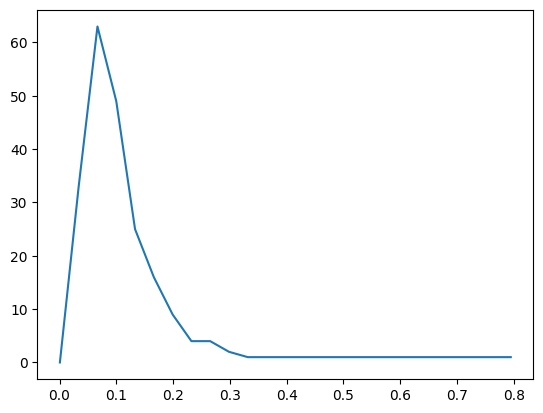

In [123]:
plt.plot(eps, num_topics)
plt.show()

In [130]:
eps =  0.23227031393346706
ensemble.recluster(eps=eps, min_samples=2, min_cores=2)

In [131]:
ensemble.print_topics()

[(0,
  '0.035*"queri" + 0.024*"search" + 0.023*"code" + 0.021*"studi" + 0.018*"reformul" + 0.009*"primari" + 0.008*"softwar" + 0.007*"base" + 0.007*"bug" + 0.007*"sourc"'),
 (1,
  '0.031*"polici" + 0.017*"access" + 0.014*"control" + 0.011*"gener" + 0.010*"base" + 0.008*"tool" + 0.008*"data" + 0.008*"extract" + 0.007*"author" + 0.006*"model"'),
 (2,
  '0.025*"decis" + 0.014*"risk" + 0.010*"make" + 0.009*"prefer" + 0.008*"seek" + 0.008*"approach" + 0.007*"research" + 0.007*"model" + 0.007*"valu" + 0.006*"abi"'),
 (3,
  '0.021*"social" + 0.019*"media" + 0.015*"epidem" + 0.013*"covid" + 0.010*"twitter" + 0.009*"health" + 0.009*"model" + 0.008*"studi" + 0.008*"data" + 0.006*"research"')]